# <center> Partial Least Squares (PLS) </center>
### <center> Jonathan Bryan and Carmen Dekmezian </center>


### Abstract

### Background
The paper we selected is titled “Partial Least Squares Regression: A Tutorial” by Geladi and Kowalski. It discusses partial least squares regression (PLSR), which is a method for decomposing values of predictors and response into more basic components and finding a robust linear relationship between the two components. PLSR was formulated by econometrician Herman Wold as a technique for "soft modelling", when the number of variables is high, the relationship between the variables is poorly understood and prediction is the primary goal. His son Svante Wold extended the use of PLSR to chemometrics to model high dimensional chemical data.

The nonexistence of a unique solution when the number of predictors is larger than the sample size of the data is a challenging problem in multiple linear regression, especially when multicollinearity and missing are also issues. Other methods that seek to reduce the dimensionality of the predictors, such as principal component analysis (PCR), allow for noise reduction and solve the collinearity problem. However, useful information for accurate prediction can be lost because PCR explains the useful directional information in the predictor space which may not be sufficiently linked to the space of new observed responses

PLSR produces X-scores, much like PCR, but also Y-scores that explain the given response space. These scores are generated by seeking important directions in the X-scores that are strongly associated with variation in the Y-scores and biased towards accurate predictions.

PLSR has several advantages over other methods. It is advantageous when the number of predictors is larger than the sample size and collinearity is high among the predictors. It is also a robust method regression because it reduces out of sample variance of residual errors and noise in the data in comparison to common multiple least squares regression algorithms. Additionally, it is beneficial when there are missing observations in the data. 

One disadvantage of PLSR is that the use of lower dimensional representations of the data and loadings of the model can make the interpretability of the important latent predictors difficult in some situations.

### Description of algorithm

PLS is a regression method used to overcome limitations discussed above for normal linear regressions (e.g., many collinear predictors, more predictors than samples, etc.) by mapping observed sets of observed variables to response variables by means of latent variables. Essentially the model assumes that the data is generated by an underlying model directed by a smaller number of latent variables in the data. 

First, two sets of latent variables are extracted from the data: $T$ (or x-scores) from the predictors, and $U$ (or y-scores) from the response variable. These latent vectors are determined through maximizing the covariance between different sets of variables. 

For the classic linear regression, we try to solve the equation, $Y = X\beta + \epsilon$, where the ordinary least squares estimate for $\beta$ is identified as $(X^T X)^{-1} X^TY$. This estimate is obtained by minimizing the sum of squared residuals. However, models that have predictors with high collinearity or more predictors than observations can result in singularity of the matrix $(X^T X)$. As an alternative and way to fix this issue, we implement the PLS algorithm throught the following steps:

1) Start with vector $u$. If there is only one response variable, then $u = y$, otherwise it is one of the columns of $Y$.

2) Calculate the weights for the predictors ($X$) :
$$w = \frac{X^Tu}{u^Tu}$$

3) Determine $t$ ($X$ scores):

$$t = Xw$$

4) Now perform similar calculations for $Y$. Calculate the weights for the response variable:
$$c = \frac{X^Tt}{t^Tt}$$

5) Determine $u$ ($Y$ scores):
$$u = \frac{Yc}{c^Tc}$$

6) If there is more than one response variable, then we test to determine whether the $t$ values have converged. If the change in $t$ from one iteration to the next, $\frac{||t_{old} - t_{new}}{||t_{new}||}$, is not smaller than a threshold value, then we iterate through steps 2-5 until convergence is reached.

7) Deflate variables for next iteration.
$$p = \frac{X^Tt}{t^Tt}$$
$$X = X - tp^T$$
$$Y = Y - tc^T$$

8) Iterate through components until they are not found to be predictive of $Y$.

In [1]:
# import packages
%matplotlib inline
import time
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn import cross_validation
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression as lin_reg
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
# load in ames home price train and test data
ames_train = pd.read_csv("ames_train.csv")
ames_test = pd.read_csv("ames_test.csv")

In [4]:
# merge both files first so there are the same number of categories created
ames_merged = pd.concat([ames_train, ames_test])
ames_merged = pd.get_dummies(ames_merged).fillna(value=0)

# save merged file to csv in folder
ames_merged[0:1500].to_csv("ames_data_train.csv")
ames_merged[1500:2000].to_csv("ames_data_test.csv")

In [5]:
# convert categorical variables to dummy variables
# create variables for train and test data separately, x for predictors, y for response
x_predictors_train = ames_merged[0:1500].drop(["price", "PID"], axis = 1)
x_predictors_test = ames_merged[1500:2000].drop(["price", "PID"], axis = 1)

y_train = ames_train.price
y_test = ames_test.price

### Algorithm: Partial Least Squares

In [6]:
def pls(path, path_test, predictors, response):
    '''Function that takes a dataframe and runs partial least squares on numeric predictors for a numeric response.
    Returns the residuals of the predictor (X block), response (Y block), and traininig RMSE'''
    combined = predictors #Ready list to combine the predictors and response to get both sets of data
    ###Data preparation
    data = pd.DataFrame.from_csv(path) #Retrieve full csv data from local machine
    combined.append(response) #Add the response to the list of variables to get from data set
    data = data[combined] #Only retrieve the predictors and response
    response_std = data[response].std() #Store the response variable standard deviation to scale the RMSE to real units at end
    
    #Subtract the mean from each column
    data = data - data.mean()

    #Scale each column by the column standard deviation
    data = data/data.std()

    #Separate in to design matrix (X block) and response column vector (Y block)
    predictors.pop() #Remove the response variable from the predictors list
    X = data[predictors].as_matrix() #Create a matrix of predictor values
    Y = data[[response]].as_matrix() #Create a matrix of predictor values
    Y_true = Y #Store the true Y values for prediction later
    
    #Get rank of matrix
    rank = np.linalg.matrix_rank(X) #Store rank of matrix because this is the maximum number of components the model can have
    
    #PLS algorithm
    u = Y #Set intital u value as response variables
    Xres_dictionary = {} #Create a dictionary for the residuals from the decomposition of the X block
    Yres_dictionary = {} #Create a dictionary for the residuals from the decomposition of the Y block
    q_new_dictionary ={} #Create a dictionary for row vectors of q loadings for the Y block
    b_dictionary = {} #Create a dictionary for scalar regression coefficient for PLS components 
    t_hat_dictionary = {} #Create a dictionary for the matrix of X scores 
    t_hat_train_dictionary = {} #Create a dictionary for the matrix of X scores for training data
    t_hat_test_dictionary = {} #Create a dictionary for the matrix of X scores for test data
    RMSE_dictionary = {} #Create a dictionary to store RMSE for training data
    RMSE_test_dictionary = {} #Create a dictionary to store RMSE for test data
    for i in range(1,(rank+1)):
        Y_pred = np.zeros((Y_true.shape[0],1))
        #Here we have one variable in the Y block so q = 1 
        #and omit steps 5-8
        q = 1

        #For the X block, u = Y
        u = Y #random y column from Y #Step 1
        w_old = np.dot(u.T,X)/np.dot(u.T,u) #Step 2
        w_new = w_old/np.linalg.norm(w_old) #Step 3
        t = np.dot(X,w_new.T)/np.dot(w_new,w_new.T) #Step 4

        #For the Y block can be omitted if Y only has one variable
        q_old = np.dot(t.T,Y)/np.dot(t.T,t) #Step 5
        q_new = q_old/np.linalg.norm(q_old) #Step 6
        q_new_dictionary[i] = q_new
        u = np.dot(Y,q_new.T)/np.dot(q_new,q_new.T) #Step 7

        #Step 8: Check convergence

        #Calculate the X loadings and rescale the scores and weights accordingly
        p = np.dot(t.T,X)/np.dot(t.T,t) #Step 9
        p_new = p.T/np.linalg.norm(p.T) #Step 10
        t_new = t/np.linalg.norm(p.T) #Step 11
        w_new = w_old/np.linalg.norm(p)  #Step 12

        #Find the regression coefficient for b for th inner relation
        b = np.dot(u.T,t_new)/np.dot(t.T,t) #Step 13
        b_dictionary[i] = b

        #Calculation of the residuals
        E_h = X - np.dot(t_new,p_new.T)
        F_h = Y - b.dot(t_new.T).T.dot(q)
        
        #Set outer relation for the X block
        Xres_dictionary[i] = E_h
        X = E_h
        
        #Set the mixed relation for the Y block
        Yres_dictionary[i] = F_h
        Y = F_h
        
        #Find estimated t hat
        t_hat = np.dot(E_h,w_new.T)
        t_hat_dictionary[i] = t_hat
        E_h = E_h - np.dot(t_hat,p_new.T)
        
        #Predict training set response by summing over different compenents
        E_h = X
        for j in range(1,i+1):
            t_hat_train = np.dot(E_h,w_new.T)
            t_hat_train_dictionary[j] = t_hat_train
            E_h = E_h - np.dot(t_hat_train, p_new.T)
            for g in range(1,i+1):
                Y_pred = Y_pred + (b_dictionary[g]*t_hat_dictionary[g]).dot(q_new_dictionary[g].T)
        
        #Find training RMSE 
        RMSE = np.sqrt(sum((Y_true - Y_pred)**2)/Y_true.shape[0]) 
        RMSE_scaled = RMSE * response_std # I believe this is the RMSE since the Y had to be scaled.
        RMSE_dictionary[i] = RMSE_scaled
        
        #Code chunk to find test RMSE
        #Load data
        data_test = pd.DataFrame.from_csv(path_test)
        combined.append(response)
        data_test = data_test[combined]
        response_std_test = data_test[response].std()
    
        #Subtract the mean from each column
        data_test = data_test - data_test.mean()

        #Scale each column by the column standard deviation
        data_test = data_test/data_test.std()

        #Separate in to design matrix (X block) and response column vector (Y block)
        predictors.pop()
        X_test = data[predictors].as_matrix()
        Y_test = data[[response]].as_matrix()
        Y_true_test = Y_test #For prediction
        
        Y_pred_test = np.zeros((Y_true_test.shape[0],1)) 
        
        #Get rank of matrix
        rank_test = np.linalg.matrix_rank(X)
        
        E_h_test = X_test
        
        #Sum over different compenents
        for k in range(1,i+1):
            t_hat_test = np.dot(E_h_test,w_new.T)
            t_hat_test_dictionary[k] = t_hat_test
            E_h_test = E_h_test - np.dot(t_hat_test, p_new.T)
            Y_pred_test = Y_pred_test + (b_dictionary[k]*t_hat_test_dictionary[k]).dot(q_new_dictionary[k].T)
        
        #Find test RMSE 
        RMSE = np.sqrt(sum((Y_true_test - Y_pred_test)**2)/Y_true_test.shape[0]) 
        RMSE_scaled_test = RMSE * response_std_test # I believe this is the RMSE since the Y had to be scaled.
        RMSE_test_dictionary[i] = RMSE_scaled_test
        
    return RMSE_dictionary, RMSE_test_dictionary

### Describe optimization for performance

In [7]:
import numba
from numba import jit

@jit
def mean_center_scale(dataframe):
    dataframe = dataframe - dataframe.mean()
    dataframe = dataframe/dataframe.std()
    return dataframe

@jit
def y_pred(Y_pred, i,b_dictionary,t_hat_dictionary,q_new_dictionary):
#Find prediction for Y based on the number of components in this iteration
    for j in range(1,i+1):
        Y_pred = Y_pred + (b_dictionary[j]*t_hat_dictionary[j]).dot(q_new_dictionary[j].T)
    return Y_pred    

@jit
def rmse(i,Y_true, Y_pred, response_std, RMSE_dictionary):
        #Find training RMSE 
        RMSE = np.sqrt(sum((Y_true - Y_pred)**2)/Y_true.shape[0])
        RMSE_scaled = RMSE * response_std # I believe this is the RMSE since the Y had to be scaled.
        RMSE_dictionary[i] = RMSE_scaled
        
        return RMSE_dictionary

@jit        
def core_pls(i,Y, X, q_new_dictionary, b_dictionary, t_hat_dictionary) :
    #Here we have one variable in the Y block so q = 1 
    #and omit steps 5-8
    q = 1

    #For the X block, u = Y
    u = Y #random y column from Y #Step 1
    w_old = np.dot(u.T,X)/np.dot(u.T,u) #Step 2
    w_new = w_old/np.linalg.norm(w_old) #Step 3
    t = np.dot(X,w_new.T)/np.dot(w_new,w_new.T) #Step 4

    #For the Y block can be omitted if Y only has one variable
    q_old = np.dot(t.T,Y)/np.dot(t.T,t) #Step 5
    q_new = q_old/np.linalg.norm(q_old) #Step 6
    q_new_dictionary[i] = q_new
    u = np.dot(Y,q_new.T)/np.dot(q_new,q_new.T) #Step 7

    #Step 8: Check convergence

    #Calculate the X loadings and rescale the scores and weights accordingly
    p = np.dot(t.T,X)/np.dot(t.T,t) #Step 9
    p_new = p.T/np.linalg.norm(p.T) #Step 10
    t_new = t/np.linalg.norm(p.T) #Step 11
    w_new = w_old/np.linalg.norm(p)  #Step 12

    #Find the regression coefficient for b for th inner relation
    b = np.dot(u.T,t_new)/np.dot(t.T,t) #Step 13
    b_dictionary[i] = b

    #Calculation of the residuals
    E_h = X - np.dot(t_new,p_new.T)
    F_h = Y - b.dot(t_new.T).T.dot(q) #WORKS BUT IS THIS RIGHT?        
    
    #Set outer relation for the X block
    #Xres_dictionary[i] = E_h #MAYBE REMOVE
    X = E_h
        
    #Set the mixed relation for the Y block
    #Yres_dictionary[i] = F_h 3MAYBE REMOVE
    Y = F_h
        
    #Find estimated t hat
    t_hat = np.dot(E_h,w_new.T)
    t_hat_dictionary[i] = t_hat
    E_h = E_h - np.dot(t_hat,p_new.T)
    
    return X,Y, u, w_new, q_new, t_new, p_new, q_new_dictionary, t_hat_dictionary, b_dictionary,E_h, F_h 
          

def pls_optimized(path, path_test, predictors, response):
    '''Function that takes a dataframe and runs partial least squares on numeric predictors for a numeric response.
    Returns the residuals of the predictor (X block), response (Y block), and traininig RMSE'''
    ###TRAINING DATA
    combined = predictors
    #Load data
    data = pd.DataFrame.from_csv(path)
    combined.append(response)
    data = data[combined]
    response_std = data[response].std()
    
    #Subtract the mean and scale each column
    data = mean_center_scale(data)

    #Separate in to design matrix (X block) and response column vector (Y block)
    predictors.pop()
    X = data[predictors].as_matrix()
    Y = data[[response]].as_matrix()
    Y_true = Y #For prediction
    
    #Get rank of matrix
    rank = np.linalg.matrix_rank(X)
   
    u = Y #set initial u as Y
    Xres_dictionary = {}
    Yres_dictionary = {}
    q_new_dictionary ={}
    b_dictionary = {}
    t_hat_dictionary = {}
    t_hat_train_dictionary = {}
    t_hat_test_dictionary = {}
    RMSE_dictionary = {}
    RMSE_test_dictionary = {}
    
    ###TEST DATA
    #Load data
    data_test = pd.DataFrame.from_csv(path_test)
    combined.append(response)
    data_test = data_test[combined]
    response_std_test = data_test[response].std()
    
    #Subtract the mean and scale each column
    data_test = mean_center_scale(data_test)

    #Separate in to design matrix (X block) and response column vector (Y block)
    predictors.pop()
    X_test = data[predictors].as_matrix()
    Y_test = data[[response]].as_matrix()
    Y_true_test = Y_test #For prediction
      
    #Get rank of matrix
    rank_test = np.linalg.matrix_rank(X_test)
    
    #Iterate through each component
    for i in range(1,(rank+1)):
        Y_pred = np.zeros((Y_true.shape[0],1))
        Y_pred_test = np.zeros((Y_true_test.shape[0],1))
        
        #Core algo
        X,Y, u, w_new, q_new, t_new, p_new, q_new_dictionary, t_hat_dictionary, b_dictionary,E_h, F_h = core_pls(i,Y, X, q_new_dictionary, b_dictionary, t_hat_dictionary)
                
        #NEW Sum over different compenents
        for g in range(1,i+1):
            t_hat_train = np.dot(E_h,w_new.T)
            t_hat_train_dictionary[g] = t_hat_train
            E_h = E_h - np.dot(t_hat_train, p_new.T)
            Y_pred = y_pred(Y_pred, g,b_dictionary,t_hat_dictionary,q_new_dictionary)
        
        #Find training RMSE 
        RMSE_dictionary = rmse(i,Y_true, Y_pred, response_std, RMSE_dictionary)
        
        #Set initial E_h as X_test data
        E_h_test = X_test
        
        #Sum over different compenents
        for k in range(1,i+1):
            t_hat_test = np.dot(E_h_test,w_new.T)
            t_hat_test_dictionary[k] = t_hat_test
            E_h_test = E_h_test - np.dot(t_hat_test, p_new.T)
            Y_pred_test = y_pred(Y_pred_test, k,b_dictionary,t_hat_test_dictionary,q_new_dictionary)
        
        #Find test RMSE 
        RMSE_test_dictionary = rmse(i,Y_true_test, Y_pred_test, response_std_test, RMSE_test_dictionary)
        
    return RMSE_dictionary, RMSE_test_dictionary

### Applications to simulated data sets

In [8]:
# generate dataset with 11 predictors (x1-x11) and a response variable y, with only 10 observations in each dataset.
# variables are made to be correlated with one another and response variable doesn't rely on all variables. 
np.random.seed(9856)
x1 = np.random.normal(5, .2, 20)
x2 = np.random.normal(7, .4, 20)
x3 = np.random.normal(9, .8, 20)

sim_data = {'x1' : x1,
            'x2' : x2, 
            'x3' : x3,
            'x4' : 5*x1,
            'x5' : 2*x2,
            'x6' : 4*x3,
            'x7' : 6*x1,
            'x8' : 5*x2,
            'x9' : 4*x3,
            'x10' : 2*x1,
            'x11' : 3*x2,
            'y' : 6*x1 + 3*x2}

pd.DataFrame(sim_data)[0:10].to_csv("sim_data_train.csv")
pd.DataFrame(sim_data)[10:20].to_csv("sim_data_test.csv")

In [9]:
sim_predictors = pd.DataFrame(sim_data).drop("y", axis = 1).columns.tolist()
sim_response = "y"
sim_data_path = 'sim_data_train.csv'
sim_data_test_path = 'sim_data_test.csv'
pls_sim_results = pls(sim_data_path, sim_data_test_path, sim_predictors, sim_response)

In [10]:
pls_optimized_sim_results = pls_optimized(sim_data_path, sim_data_test_path, sim_predictors, sim_response)

### Applications to real data sets

In the paper we selected, the authors don’t include real-world examples with data that we can test on. Thus, we decided to test the algorithm on a publicly available dataset that we investigated for our predictive modeling class. This data contains information on residential properties in Ames, Iowa, with variables that describe characteristics of each home and a variable indicating the home’s value.[ref: Decook]

We decided to use this dataset because it contains many correlated variables, some of which have very similar meanings. For example, the dataset includes the variables Garage.qual and Garage.cond, both of which can take on values of: Ex (excellent), Gd (good), TA (typical/average), Fa (fair), Po (Poor), or NA (no garage). Additionally, since there are so many different factor/categorical variables in the dataset, the total number of predictors becomes 288 when trying to estimate a coefficient for each level. Since these characteristics play into the strength of the PLS method, PLS method is beneficial 

With this data, we were trying to predict a home’s price based on its attributes. The limitations of the data, including the number of predictors and collinearity, suggest that the PLS method will be beneficial for predictions and accuracy.

In [11]:
predictors = x_predictors_train.columns.tolist()
response = "price"
path = 'ames_data_train.csv'
path_test = 'ames_data_test.csv'
pls_reg_results = pls(path, path_test, predictors, response)
pls_reg_opt_results = pls_optimized(path, path_test, predictors, response)

In [12]:
pls_reg_speed = %timeit -o -q pls(path, path_test, predictors, response)

In [13]:
pls_reg_opt_speed = %timeit -o -q pls_optimized(path, path_test, predictors, response)

In [14]:
def get_list(input_dict):
    '''input dictionary with key/values, and then output the list of values'''
    length = len(input_dict)
    x = list(range(1, length + 1 , 1))

    mykeys = input_dict.keys()
    value_list =[input_dict[x] for x in mykeys]
    value_list = [ int(x) for x in value_list ]
    return value_list

<function matplotlib.pyplot.show>

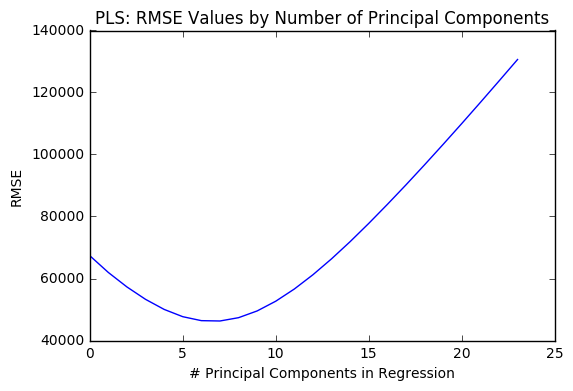

In [15]:
pls_rmse_list = get_list(pls_reg_results[0])

plt.plot(pls_rmse_list)
plt.title("PLS: RMSE Values by Number of Principal Components")
plt.xlabel("# Principal Components in Regression")
plt.ylabel("RMSE")
plt.show

In [16]:
# get minimum rmse values using the pls method and the optimized pls method
pls_rmse_test_list = get_list(pls_reg_results[1])
pls_opt_rmse_test_list = get_list(pls_reg_opt_results[1])

In [17]:
# compare accuracy and speed for the pls method (optimized and not) 
pls_comparison = {'RMSE' : [min(pls_rmse_test_list), min(pls_opt_rmse_test_list)], 'Speed' : [pls_reg_speed.best, pls_reg_opt_speed.best]}
pd.DataFrame(pls_comparison, index=['PLS', 'PLS Optimized'])

,RMSE,Speed
PLS,46178,0.444151
PLS Optimized,46178,0.242239


### Comparative analysis with competing algorithms

With the Ames housing data, we decided to test our PLS results above with the standard OLS regression and the PCR method. In the OLS regression, we tried predicting price using all of the variables in the dataset. The model is as follows:
$$y = X\beta + \epsilon$$
$$y = \beta_0 + x_1\beta_1 + ... + x_p\beta_p + \epsilon$$ 
$$y = \beta_0 + area^*\beta_{area} + ... + Lot.Config^*\beta_{Lot.Config} + \epsilon$$ 
where we have $p$ predictors available in the data.

For the OLS model, $\beta$ is estimated by minimizing the sum of squared errors and can be express as $(X^T X)^{-1} X^TY$. All predictors are used in estimating the $\beta$ coefficients. The PCR regression is similar to the PLS regression in that it selects a subset of features out of the larger number of predictors to include in the model. In the PCR model, the predictors are first scaled and then we perform 10-fold cross-validation on the model with varying numbers of predictors (from 0, which is a model with just the intercept, up to the total number of predictors). We find the model with the smallest RMSE to identify the number of principal components to be used in the final model (see the plot below for a visualization). Using that set of predictors, we predict the house price on the test data and calculate the RMSE.

### Simple Algorithm: OLS

In [18]:
def run_ols_reg(x_train, y_train, x_test, y_test):
    '''Run ordinary least squares regression on set of x predictors and y response variable.
    Fit on training data and predict on test data. Output RMSE of model.'''

    # run ols on home price model
    ols_reg = lin_reg().fit(x_train, y_train)
    y_test_pred_ols = ols_reg.predict(x_test)
    ols_rmse_test = sqrt(mean_squared_error(y_test, y_test_pred_ols))
    
    return ols_rmse_test

### Alternative Algorithm: PCR

In [19]:
def cross_val(x_data, y_data, num_folds):
    '''Perform k-fold cross-validation on training data'''
    
    # perform cross validation (k-fold)
    n = len(x_data)
    cross_val_k_10 = cross_validation.KFold(n, n_folds = 10, shuffle = True, random_state = 1)
    rmse = []

    # calculate rmse values for intercept (no predictors/components)
    mean_sq_error = -1*cross_validation.cross_val_score(lin_reg(), np.ones((n,1)), y_data.ravel(), cv = cross_val_k_10, scoring = "neg_mean_squared_error").mean()
    rmse.append(sqrt(mean_sq_error))
    
    # calculate rmse values for varying numbers of predictors/components
    for i in range(1, x_data.shape[1]):
        mean_sq_error = -1*cross_validation.cross_val_score(lin_reg(), x_data[:,:i], y_data.ravel(), cv = cross_val_k_10, scoring = "neg_mean_squared_error").mean()
        rmse.append(sqrt(mean_sq_error))
    
    return rmse

In [20]:
def run_pcr_reg(x_train, y_train, x_test, y_test):
    '''Run ordinary least squares regression on set of x predictors and y response variable.
    Fit on training data and predict on test data. Output RMSE (both training and test data).'''

    # scale x train data
    x_scaled_train = PCA().fit_transform(scale(x_train))

    pcr_rmse = cross_val(x_scaled_train, y_train, 10)

    # find number of principal components with smallest rmse
    n_pcr_comps = pcr_rmse.index(min(pcr_rmse))

    # run regression using specific number of principal components
    pcr_reg = lin_reg().fit(x_scaled_train[:,:n_pcr_comps], y_train)

    # use regression above to predict on test data
    x_scaled_test = PCA().fit_transform(scale(x_test))[:,:n_pcr_comps]
    y_test_pred_pcr = pcr_reg.predict(x_scaled_test)
    pcr_rmse_test = sqrt(mean_squared_error(y_test, y_test_pred_pcr))
    
    return pcr_rmse, pcr_rmse_test

In [21]:
# run ols
ols_reg_results = run_ols_reg(x_predictors_train, y_train, x_predictors_test, y_test)

In [22]:
# ols speed
ols_speed = %timeit -o -q run_ols_reg(x_predictors_train, y_train, x_predictors_test, y_test)

In [23]:
# run pcr
pcr_reg_results = run_pcr_reg(x_predictors_train, y_train, x_predictors_test, y_test)

In [24]:
pcr_speed = %timeit -o -q run_pcr_reg(x_predictors_train, y_train, x_predictors_test, y_test)

In [25]:
# summary of all methods, accuracy and speed
diff_methods_summary = {'RMSE' : [min(pls_rmse_test_list), min(pls_opt_rmse_test_list), pcr_reg_results[1], ols_reg_results], 'Speed' : [pls_reg_speed.best, pls_reg_opt_speed.best, pcr_speed.best, ols_speed.best]}
pd.DataFrame(diff_methods_summary, index=['PLS', 'PLS Optimized', 'PCR', 'OLS'])

,RMSE,Speed
PLS,46178.000000,0.444151
PLS Optimized,46178.000000,0.242239
PCR,67014.500338,0.502869
OLS,40592.231387,0.001790


<function matplotlib.pyplot.show>

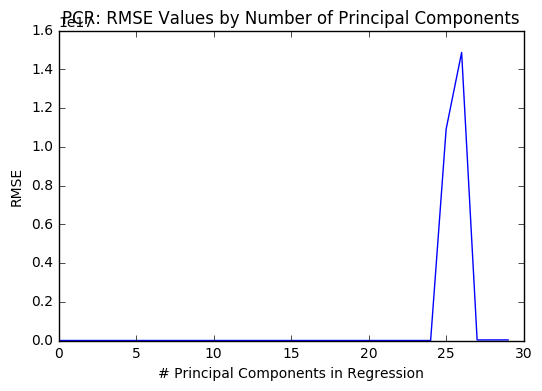

In [26]:
# plot pcr
plt.plot(pcr_reg_results[0])
plt.title("PCR: RMSE Values by Number of Principal Components")
plt.xlabel("# Principal Components in Regression")
plt.ylabel("RMSE")
plt.show

### Discussion/Conclusion



### References

Geladi, P., and Kowalski, B. R.. 1986. “Partial Least-Squares Regression: a Tutorial,” Analytica Chimica Acta, 185, 1 (1986).

Tobias, R. D.. 2003. An Introduction to partial least squares regression <http://www.ats.ucla.edu/stat/sas/library/pls.pdf>.

Mevik, B-J, Wehrens R, Liland KH. 2011. R Package: ‘pls’: Partial Least Squares and Principal Component regression.

Frank, I. E. and Friedman, J. H.. 1993. A statistical view of some chemometrics regression tools. Technometrics 35: 109–135.

Wold, S. et al. 2001. PLS regression: a basic tool of chemometrics. Chemometr. Intell. Lab. 58: 109–130.

Abdi, H.. 2007. Partial least square regression (PLS regression). – In: Salkind, N. J. (ed.), Encyclopedia of measurement and statistics. Sage.

DeCock, D.. 2011. Ames, Iowa: Alternative to the Boston housing data as an end of semester regression project. J. Statist. Ed. 19(3):1–15.

Crouser, J. 2016. Lab 11 - PCR and PLS Regression in Python. 
<http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11/Lab%2011%20-%20PCR%20and%20PLS%20Regression%20in%20Python.pdf>.